In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [3]:
tf.enable_eager_execution()

In [4]:
batch_size = 8
depth = 256
num_keypoints = 256
training = True
num_heads = 2
num_layers = 2

In [5]:
from superglue.layers import SuperGlue
from superglue.losses import AugmentedSinkhornKnoppLayer, get_assignment_loss

In [6]:
model = SuperGlue(depth=depth, num_layers=num_layers, num_heads=num_heads)
optimal_assignment = AugmentedSinkhornKnoppLayer(lam=5, num_steps=100)

In [7]:
input_dA = tf.keras.layers.Input(shape=[num_keypoints, depth])
input_pA = tf.keras.layers.Input(shape=[num_keypoints, 2])

input_dB = tf.keras.layers.Input(shape=[num_keypoints, depth])
input_pB = tf.keras.layers.Input(shape=[num_keypoints, 2])

input_pij_labels = tf.keras.layers.Input(shape=[num_keypoints+1, num_keypoints+1], dtype=tf.float32)

In [9]:
fA, fB = model([input_dA, input_pA, input_dB, input_pB], training=training)

In [10]:
# model.summary()

In [11]:
fA.shape, fB.shape

(TensorShape([Dimension(None), Dimension(256), Dimension(256)]),
 TensorShape([Dimension(None), Dimension(256), Dimension(256)]))

In [12]:
Pij, Sij = optimal_assignment([fA, fB])

In [13]:
Pij, Sij

(<tf.Tensor 'augmented_sinkhorn_knopp_layer/Identity:0' shape=(?, 257, 257) dtype=float32>,
 <tf.Tensor 'augmented_sinkhorn_knopp_layer/Identity_1:0' shape=(?, 256, 256) dtype=float32>)

In [14]:
super_glue_model = tf.keras.models.Model(inputs=[input_dA, input_pA, input_dB, input_pB], outputs=Pij)

In [15]:
super_glue_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 256, 2)]     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256)]   0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256, 2)]     0                                            
______________________________________________________________________________________________

In [16]:
from superglue.datasets import superpoint_image_pair_generator

image_size = (384, 384)

train_generator = superpoint_image_pair_generator(
    images_dir="/home/mkk/Downloads/superglue/images/",
    model_dir="/home/mkk/Downloads/superglue/model/sp_v5/",
    image_size=image_size,
    num_matches = num_keypoints
)

In [17]:
output_shapes = (
    (
        tf.TensorShape([num_keypoints, depth]),
        tf.TensorShape([num_keypoints, 2]),
        tf.TensorShape([num_keypoints, depth]),
        tf.TensorShape([num_keypoints, 2])
    ),
    (
        tf.TensorShape([num_keypoints+1, num_keypoints+1])
    )
)

dataset = tf.data.Dataset.from_generator(
    lambda: train_generator, ((tf.float32, tf.float32, tf.float32, tf.float32), tf.float32),
    output_shapes=output_shapes
)
dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [18]:
dataset

<DatasetV1Adapter shapes: (((?, 256, 256), (?, 256, 2), (?, 256, 256), (?, 256, 2)), (?, 257, 257)), types: ((tf.float32, tf.float32, tf.float32, tf.float32), tf.float32)>

In [19]:
next(iter(dataset))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


((<tf.Tensor: id=19565, shape=(8, 256, 256), dtype=float32, numpy=
  array([[[-8.33017007e-02,  5.35880215e-02,  5.12117731e-05, ...,
           -1.20584011e-01,  6.13590442e-02,  2.69366633e-02],
          [-6.91743940e-03, -1.75451636e-02,  4.27291952e-02, ...,
           -3.87174189e-02, -2.21155528e-02, -1.46379555e-02],
          [-1.00072123e-01,  1.60250086e-02, -3.95568786e-03, ...,
           -6.83865473e-02, -2.67518368e-02, -2.28048861e-03],
          ...,
          [-2.26598065e-02,  1.61064491e-02, -1.39364913e-01, ...,
           -7.04596639e-02,  1.25960512e-02,  4.11118120e-02],
          [ 3.05350833e-02, -4.63139489e-02,  3.78151909e-02, ...,
            4.60259058e-02,  1.36060864e-01, -1.54863909e-01],
          [-6.90341368e-02, -4.82755639e-02,  2.85729971e-02, ...,
           -1.69873349e-02,  1.05738759e-01, -4.85750325e-02]],
  
         [[-4.89026494e-02, -2.12332723e-03,  4.96322811e-02, ...,
           -1.11695297e-01,  5.44409007e-02, -8.32530204e-03],
    

In [20]:
dataset

<DatasetV1Adapter shapes: (((?, 256, 256), (?, 256, 2), (?, 256, 256), (?, 256, 2)), (?, 257, 257)), types: ((tf.float32, tf.float32, tf.float32, tf.float32), tf.float32)>

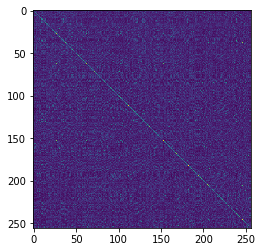

In [21]:
predicted_pij = super_glue_model.predict_generator(dataset, steps=1)
plt.imshow(predicted_pij[0][:-1, :-1])

In [22]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
super_glue_model.compile(optimizer=optimizer, loss=get_assignment_loss(1 / num_keypoints))

In [ ]:
super_glue_model.fit(dataset, epochs=1, steps_per_epoch=5)

2/5 [===========>..................] - ETA: 58s - loss: 5.0428 

In [1]:
optimal_assignment.weights

NameError: name 'optimal_assignment' is not defined

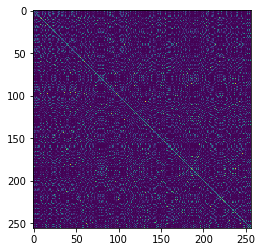

In [24]:
predicted_pij = super_glue_model.predict_generator(dataset, steps=1)
plt.imshow(predicted_pij[0][:-1, :-1])